In [238]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn
import math

READ THE CLEANED DATA

-relative abundance 

-microbiome HD is concatenated

-merged with meta data - healthy vs disease


In [239]:
dataHD = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_microbiomeHD_versionA")
dataAmericans = pd.read_csv("C:/Users/talno/microbiom_project/cleaned_Americans_versionA", low_memory=False)

In [240]:
dataHD.drop(columns='Unnamed: 0', inplace=True)
dataAmericans.drop(columns='Unnamed: 0', inplace=True)

In [194]:
keep_features = [i for i in dataHD.columns if i in dataAmericans.columns]
n = len(keep_features)
print("features left: ", n)

features left:  139


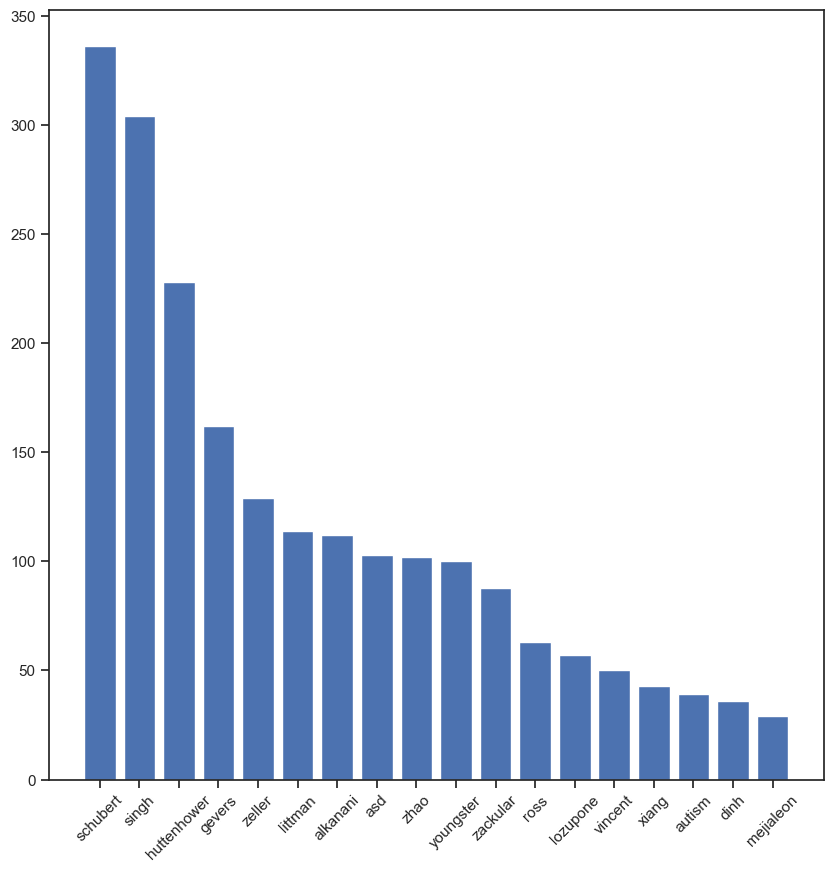

In [195]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(np.arange(0, len(dataHD.From.value_counts())), dataHD.From.value_counts())
plt.xticks(np.arange(0, len(dataHD.From.value_counts())), list(dataHD.From.value_counts().keys()), rotation=45)
plt.show()
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/samples_number.png')


In [196]:
dataHD_filtered = dataHD.loc[:,keep_features]
dataAmericans_filtered = dataAmericans.loc[:,keep_features]
print(dataAmericans_filtered.shape, dataHD_filtered.shape)


(9509, 139) (2095, 139)


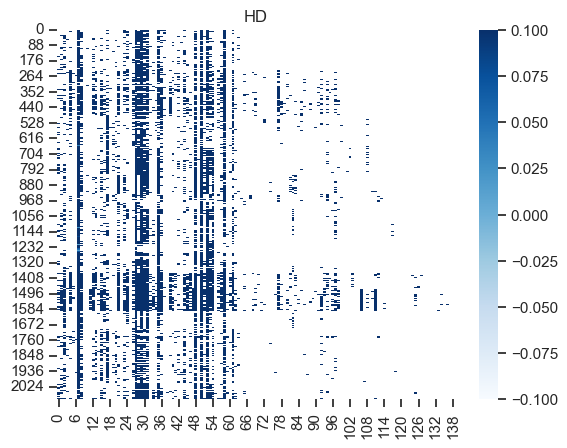

In [197]:
%matplotlib inline
np.seterr(divide = 'ignore')
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
plt.figure()
plt.xticks(range(n), keep_features)
plt.yticks(range(len(dataHD_filtered)))
plt.title('HD')
plot = seaborn.heatmap(-np.log(dataHD_filtered.values), cmap="Blues")
# plt.show()
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/HD_headtmap.png')


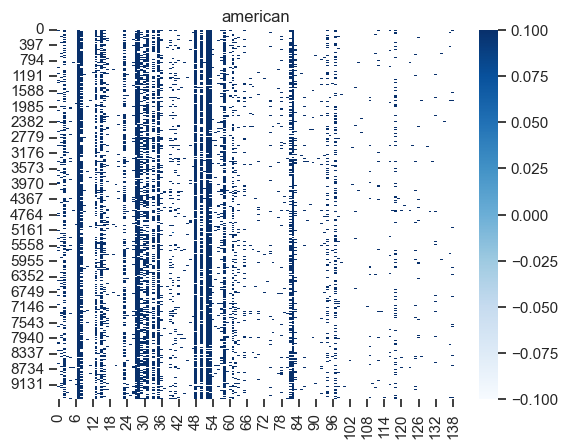

In [198]:
plt.figure()
plt.xticks(range(n), keep_features, rotation=90)
plt.yticks(range(len(dataAmericans_filtered)))
plt.title('american')
plot = seaborn.heatmap(-np.log(dataAmericans_filtered.values), cmap="Blues")
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/Americans_headtmap.png')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

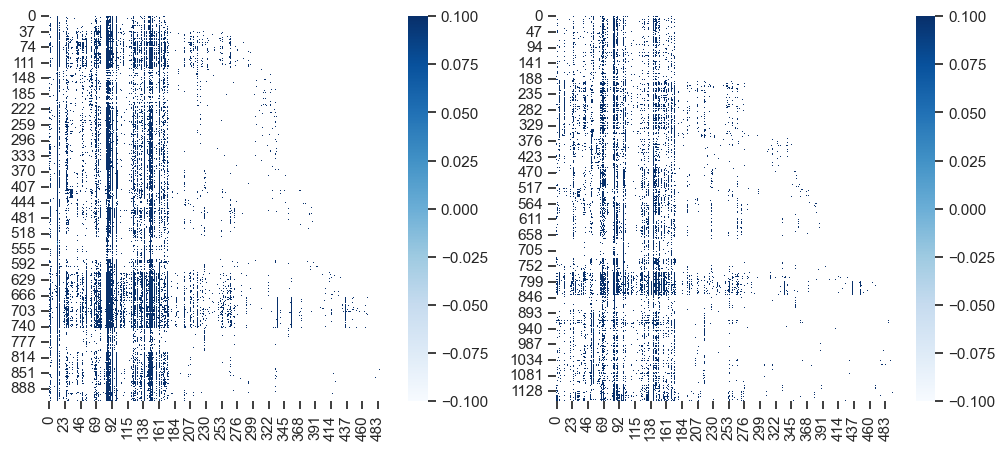

In [199]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
Healthy = dataHD.query("DiseaseState == 'H'").drop(columns=["DiseaseState", "From"])
Disease = dataHD.query("DiseaseState == 'D'").drop(columns=["DiseaseState", "From"])
seaborn.heatmap(-np.log(Healthy.values), cmap="Blues", ax=axes[0])
seaborn.heatmap(-np.log(Disease.values), cmap="Blues", ax=axes[1])
np.seterr(divide = 'warn')

After dropping features- whats left...

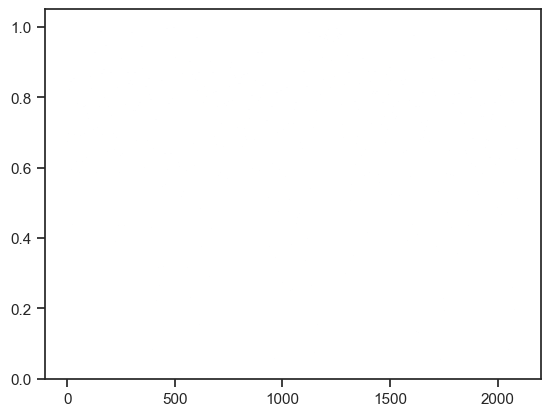

In [200]:

plt.bar(np.arange(0, len(dataHD_filtered)), list(dataHD_filtered.sum(axis=1)))
plt.show()
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/Remaining_percentage_after_filter.png')

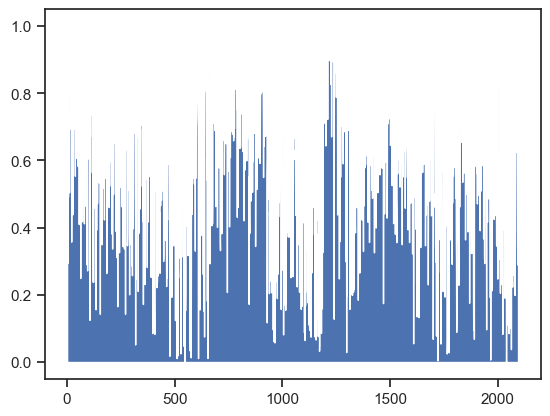

In [201]:
from scipy.interpolate import make_interp_spline, BSpline

#create data
x = np.arange(0, len(dataHD_filtered))
y = np.array(list(dataHD_filtered.sum(axis=1)))

plt.fill_between(x, y,0, alpha=1)
# plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/Remaining_percentage_after_filter2.png')


In [202]:
all_data = pd.concat([dataAmericans_filtered, dataHD_filtered])

PCA- fit both data

In [203]:
pca = PCA(n_components=2)
pca.fit(dataAmericans_filtered)
components_americans1 = pca.transform(dataAmericans_filtered)
components_HD1 = pca.transform(dataHD_filtered)
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_americans1 = pd.DataFrame(data= components_americans1, columns= ['Pc1', 'Pc2'])
pca_HD1 = pd.DataFrame(data= components_HD1, columns= ['Pc1', 'Pc2'])


explained variance:  0.5327412907315144


PCA- fit only american

In [204]:
pca = PCA(n_components=2)
pca.fit(all_data)
components_americans2 = pca.transform(dataAmericans_filtered)
components_HD2 = pca.transform(dataHD_filtered)
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_americans2 = pd.DataFrame(data= components_americans2, columns= ['Pc1', 'Pc2'])
pca_HD2 = pd.DataFrame(data= components_HD2, columns= ['Pc1', 'Pc2'])

explained variance:  0.5890665615090999


PCA- all data vs only american's

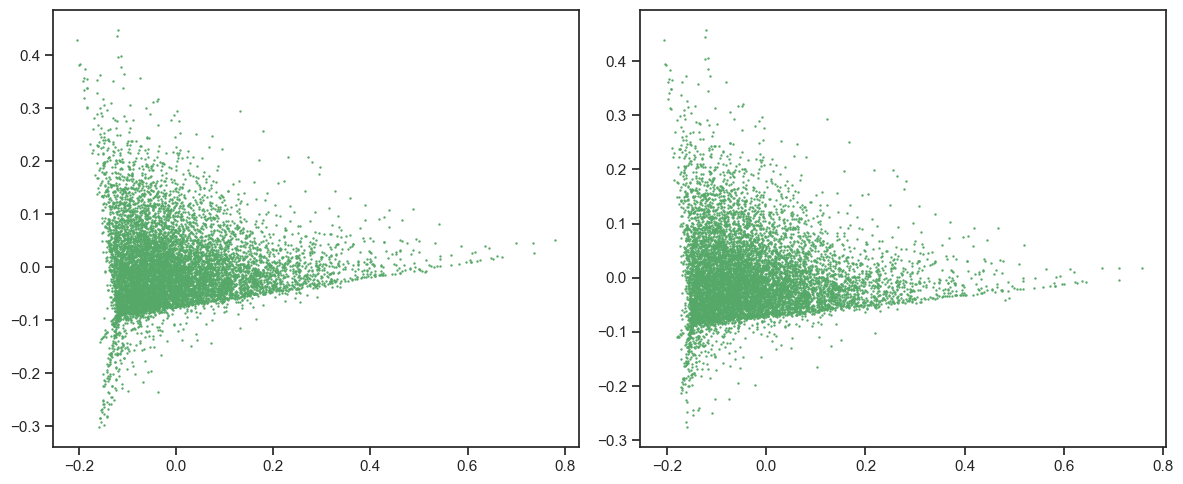

In [205]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
axes[1].scatter(pca_americans2.loc[:,'Pc1'], pca_americans2.loc[:,'Pc2'],marker='.',s=2, color= 'g')
fig.tight_layout()
plt.savefig('C:/Users/talno/microbiom_project/microbiome_dysbiosis/microbiome_dysbiosis/figures/americans_pca_vs_all_pca.png')
plt.show()

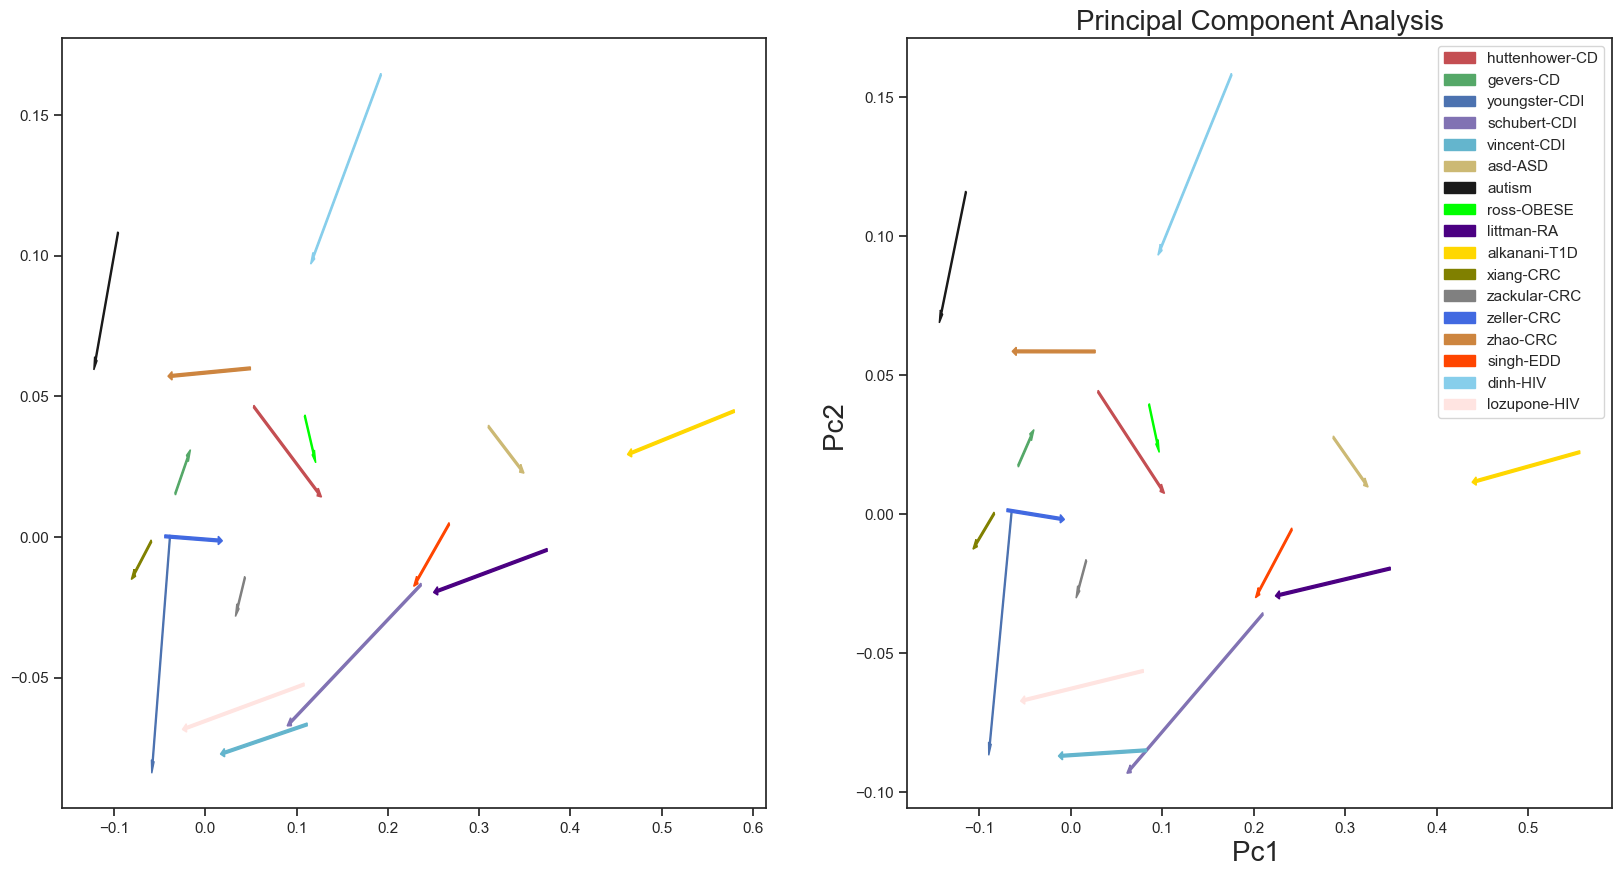

In [206]:
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
itr = [pca_HD1, pca_HD2]
polar_data = dict()
for i, pca_HD in enumerate(itr):
    plt.xlabel('Pc1 ', fontsize=20)
    plt.ylabel('Pc2 ', fontsize=20)
    plt.title("Principal Component Analysis",fontsize=20)

    targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]
    colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
    arrows, var_x, var_y, angles, sizes = [], [], [], [], []
    # axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
    for target, color in zip(targets,colors):
        indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['DiseaseState'] == target[1])
        fill = 'none'
        if target[1] == "D":
            fill = color
        x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
        x_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc1'].values)
        y_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc2'].values)
        var_x.append(x_v)
        var_y.append(y_v)
        arrows.append(x)
        arrows.append(y)
        # axes[i].scatter(pca_HD.loc[indicesToKeep.values, 'Pc1'] , pca_HD.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)
    # find centroids and plotting an arrow
    col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
    for j in range(0,len(arrows),4):
        axes[i].arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4])
        angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
        sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
    L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
    plt.legend(L) 
    polar_data[i] = [var_x, var_y, angles, sizes]
# fig.show()

In [207]:
disease = ["CD","CDI","autism", "Obese", "RA","T1D","CRC","EDD","HIV"]
disease_map = {"CD":["huttenhower", "gevers", "N", "N"],"CDI":["youngster", "schubert","vincent", "N"],"autism":['asd', 'autism', "N", "N"], "Obese":['ross', "N", "N", "N"], "RA":['littman', "N", "N", 'N'],"T1D":['alkanani', "N", "N", 'N'],"CRC":["xiang","zackular","zeller","zhao"],"EDD":['singh', "N", "N", "N"],"HIV":['dinh',"lozupone", "N", "N"]}


In [208]:
def pca_disease(disease):
    arrows = []
    data_partial = dataHD[(dataHD['From'] == disease_map[disease][0]) | (dataHD['From'] == disease_map[disease][1]) | (dataHD['From'] == disease_map[disease][2]) | (dataHD['From'] == disease_map[disease][3])]
    keep_features = [i for i in data_partial.columns if i in dataAmericans.columns and data_partial[i].sum() > 0.1] 
    print(len(keep_features))  
    data_filtered = data_partial.loc[:,keep_features]
    dataAmericans_filtered = dataAmericans.loc[:,keep_features]     
    pca = PCA(n_components=2)
    pca.fit(pd.concat([dataAmericans_filtered, data_filtered]))
    components_americans = pca.transform(dataAmericans_filtered)
    components_disease = pca.transform(data_filtered)
    print("explained variance: ", sum(pca.explained_variance_ratio_))
    pca_americans = pd.DataFrame(data= components_americans, columns= ['Pc1', 'Pc2'])
    pca_disease = pd.DataFrame(data= components_disease, columns= ['Pc1', 'Pc2'])  
    
    plt.xlabel('Pc1 ', fontsize=10)
    plt.ylabel('Pc2 ', fontsize=10)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = disease_map[disease]
    colors = ['r','c', 'b','lime']
    # plt.scatter(pca_americans.loc[:,'Pc1'], pca_americans.loc[:,'Pc2'],marker='.',s=2, color= 'g')
    for target, color in zip(targets,colors):
        indicesToKeep = (data_partial['From'] == target) & (data_partial['DiseaseState'] == 'H')
        x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
        arrows.append(x)
        arrows.append(y)  
        # plt.scatter(pca_disease.loc[indicesToKeep.values, 'Pc1'] , pca_disease.loc[indicesToKeep.values, 'Pc2'], c=color, edgecolors=color, s=50)
        indicesToKeep = (data_partial['From'] == target) & (data_partial['DiseaseState'] == 'D')
        x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
        y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
        arrows.append(x)
        arrows.append(y)  
        # plt.scatter(pca_disease.loc[indicesToKeep.values, 'Pc1'] , pca_disease.loc[indicesToKeep.values, 'Pc2'], c='none', edgecolors=color, s=50)
    
    # find centroids and plotting an arrow
    col = ['r', 'c', 'b', 'lime']
    for j in range(0,len(arrows),4):
        plt.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4])
    plt.legend(targets) 
    # fig.show() 

                              

24
explained variance:  0.6757711180781609


C:\Users\talno\AppData\Local\Temp\ipykernel_23088\2603910077.py:24: RuntimeWarning: Mean of empty slice.
  x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\talno\AppData\Local\Temp\ipykernel_23088\2603910077.py:25: RuntimeWarning: Mean of empty slice.
  y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()
C:\Users\talno\AppData\Local\Temp\ipykernel_23088\2603910077.py:30: RuntimeWarning: Mean of empty slice.
  x = pca_disease.loc[indicesToKeep.values, 'Pc1'].values.mean()
C:\Users\talno\AppData\Local\Temp\ipykernel_23088\2603910077.py:31: RuntimeWarning: Mean of empty slice.
  y = pca_disease.loc[indicesToKeep.values, 'Pc2'].values.mean()


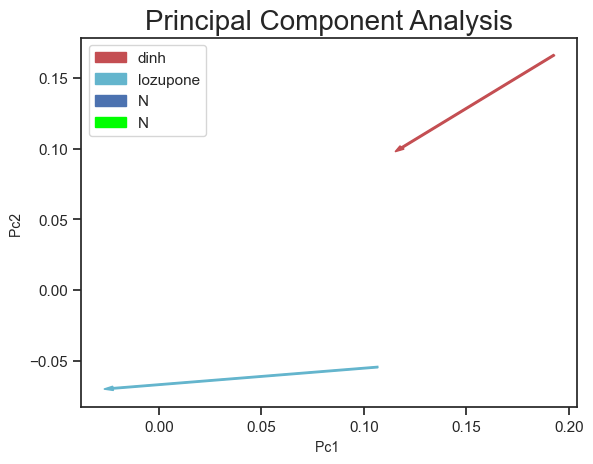

In [209]:
pca_disease("HIV")

POLAR PLOT

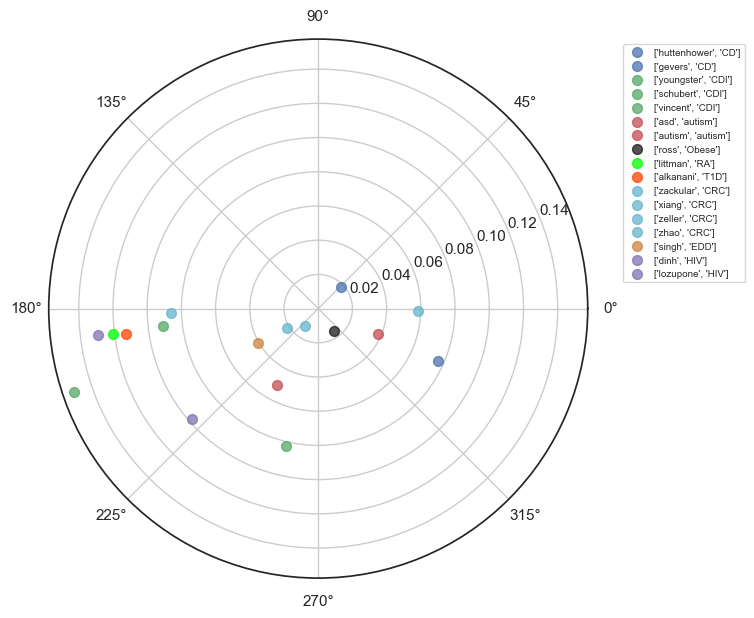

In [210]:
from matplotlib.patches import Ellipse
colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]
var_x, var_y, angles, sizes = polar_data[0]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    # ax.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    c = ax.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=50)
    # c = ax.scatter(angle, size, c=color, alpha=0.75, s=50)
plt.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

Now only for the microbiomeHD PCA.

explained variance:  0.4777615573765858


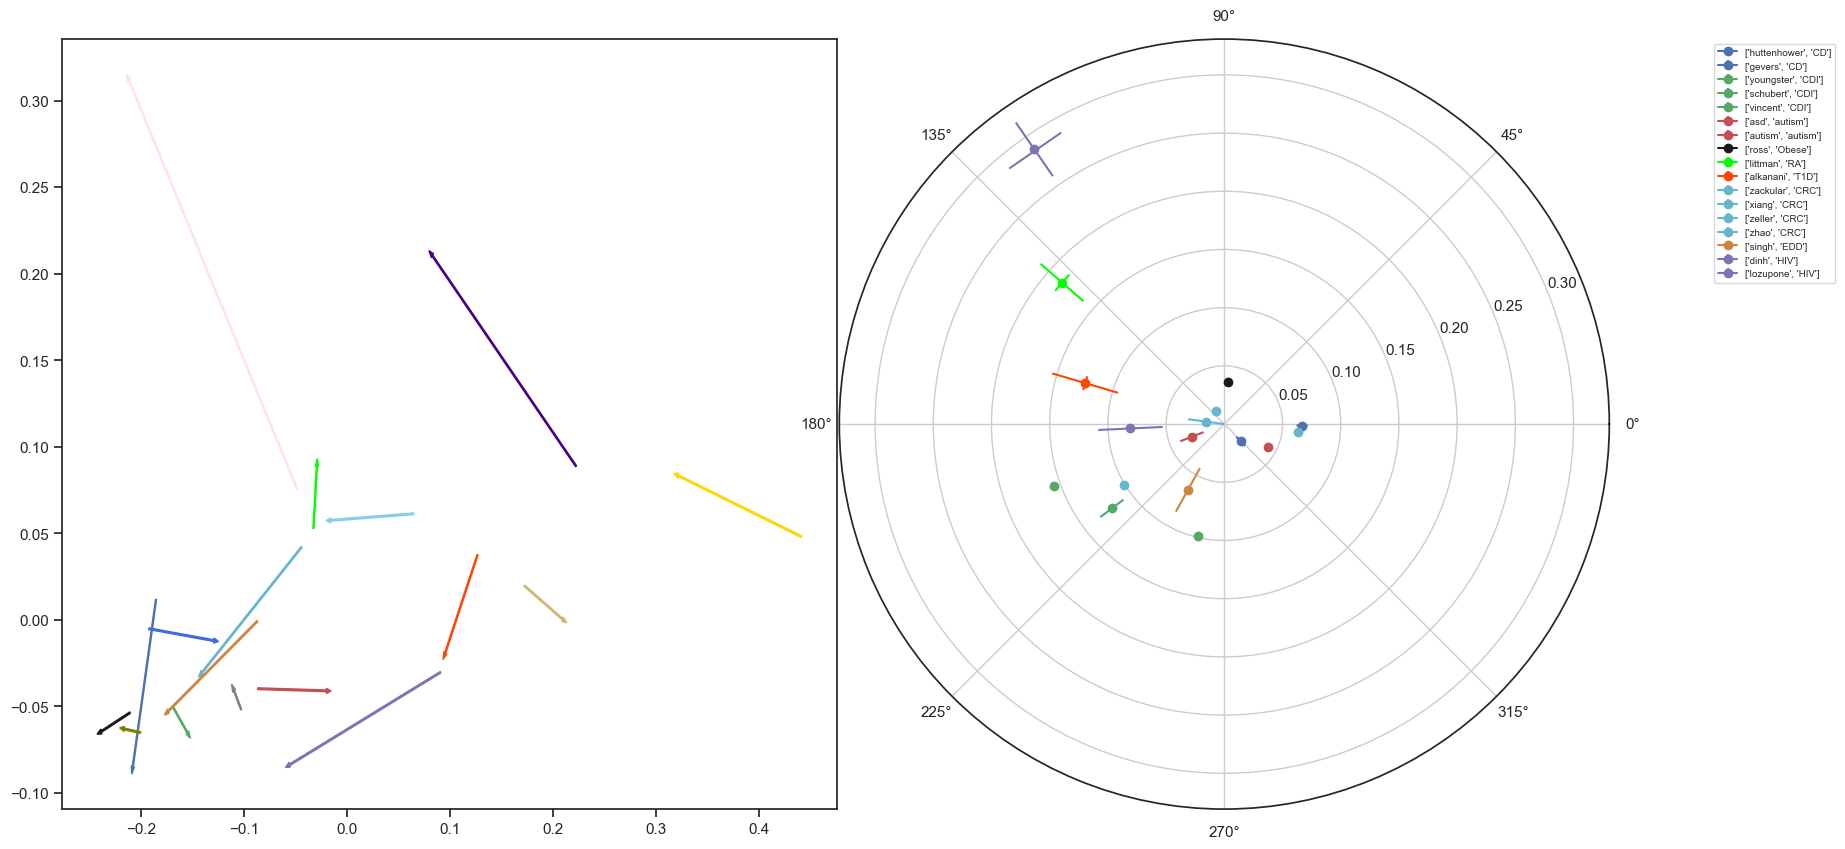

In [211]:
pca = PCA(n_components=2)
components_HD = pca.fit_transform(dataHD.drop(columns=['DiseaseState', 'From']))
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_HD = pd.DataFrame(data= components_HD, columns= ['Pc1', 'Pc2'])

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, polar=True)
# plt.xlabel('Pc1 ', fontsize=20)
# plt.ylabel('Pc2 ', fontsize=20)
# plt.title("Principal Component Analysis",fontsize=20)
targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]
colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
arrows, var_x, var_y, angles, sizes = [], [], [], [], []
# axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
for target, color in zip(targets,colors):
    indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['DiseaseState'] == target[1])
    fill = 'none'
    if target[1] == "D":
        fill = color
    x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
    y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
    x_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc1'].values)
    y_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc2'].values)
    var_x.append(x_v)
    var_y.append(y_v)
    arrows.append(x)
    arrows.append(y)
    # axes[0].scatter(pca_HD.loc[indicesToKeep.values, 'Pc1'] , pca_HD.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)
# find centroids and plotting an arrow
col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
for j in range(0,len(arrows),4):
    ax1.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4])
    angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
    sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
plt.legend(L) 

colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]

for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    ax2.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax2.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    # c = ax2.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=50)
    # c = ax2.scatter(angle, size, c=color, alpha=0.75, s=50)
ax2.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()

STATISTICS

In [212]:
new_df = pd.DataFrame({'angles': np.rad2deg(angles), 'length': sizes, 'names': np.array(L)[:,0], 'disease': np.array(L)[:,1]})
new_df

,angles,length,names,disease
0,-1.067071,0.066789,huttenhower,CD
1,-46.575801,0.020414,gevers,CD
2,-103.124975,0.099082,youngster,CDI
3,-159.954362,0.155882,schubert,CDI
4,-143.136500,0.120676,vincent,CDI
5,-27.531425,0.041884,asd,autism
6,-158.713915,0.029836,autism,autism
7,84.692321,0.036093,ross,Obese
8,138.903699,0.185034,littman,RA
9,163.590985,0.124649,alkanani,T1D


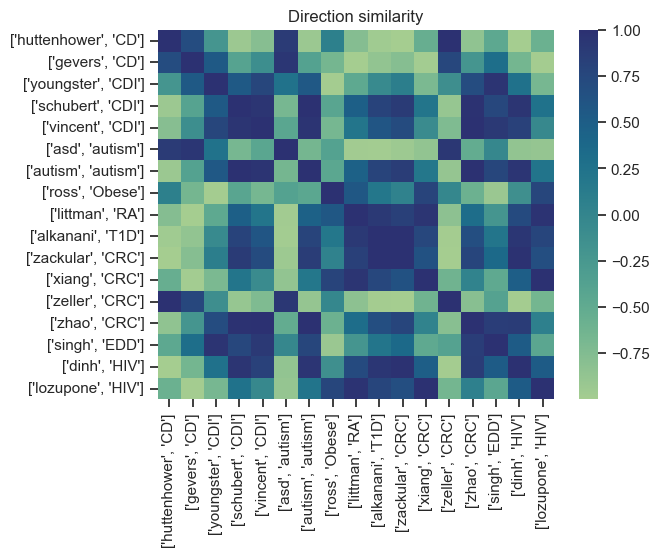

In [213]:
mat = [[0 for i in range(len(angles))] for j in range(len(angles))]
disease = ["CD","CDI","autism", "Obese", "RA","T1D","CRC","EDD","HIV"]
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]
helper = {"CD":[0,1],"CDI":[2,3,4],"autism":[5,6], "Obese":[7], "RA":[8],"T1D":[9],"CRC":[10,11,12,13],"EDD":[14],"HIV":[15,16]}
angles1 = np.rad2deg(angles)
n = len(disease)
for i in range(len(angles1)):
    for j in range(i,len(angles1)):
        diff = min(abs(angles1[i]-angles1[j]),360-abs(angles1[i]-angles1[j]))
        mat[i][j] = math.cos(math.radians(diff))
        mat[j][i] = mat[i][j]

mat_disease = [[0]*n for i in range(n)]
for i in range(n):
    for key,vals in helper.items():
        idx = disease.index(key)
        for val in vals:
            for x in helper[disease[i]]:
                mat_disease[i][idx] += mat[x][val]
        mat_disease[i][idx] /= len(vals)*len(helper[disease[i]])

plt.figure()
plt.title('Disease Similarity matrix',fontsize=20)
plt.title('Direction similarity')
plt.xticks(range(n), disease, rotation=90)
plt.yticks(range(n), disease)
plot = seaborn.heatmap(mat,xticklabels=L, yticklabels=L,cmap="crest")
plt.show()

In [214]:
new_df['similarity'] = mat

In [294]:
new_df['similarity']

0     [0.7008005862145079, -0.20890010390839417, -0....
1     [0.7008005862145079, 0.5512211039654038, -0.39...
2     [-0.20890010390839417, 0.5512211039654038, 0.5...
3     [-0.9328736563748634, -0.3968044559916376, 0.5...
4     [-0.7887562047329331, -0.11425573468304479, 0....
5     [0.8952117930425267, 0.9452661346773966, 0.248...
6     [-0.9248572779513938, -0.3768405211577095, 0.5...
7     [0.07394501087025632, -0.6595835799200837, -0....
8     [-0.7657164193598106, -0.9954304283144855, -0....
9     [-0.9643639931157387, -0.8645662503994723, -0....
10    [-0.9933502803414099, -0.7782702174357985, 0.0...
11    [-0.5506864013239285, -0.9813693492187293, -0....
12    [0.9959759278356357, 0.7619124120099156, -0.12...
13    [-0.8475195691330034, -0.2153177687719904, 0.6...
14    [-0.4676198737065054, 0.30284933661881597, 0.9...
15    [-0.997863653462132, -0.6526991491969517, 0.27...
16    [-0.5839213614659383, -0.9883231272178956, -0....
Name: similarity, dtype: object

In [291]:
new_df['similarity'] = [np.delete(new_df['similarity'][i], i) for i in range(17)]

In [285]:
new_df['pred'] = [np.delete(np.array((new_df['disease'] == new_df['disease'][i]).values*1),i) for i in range(17)]

In [286]:
new_df['pred'] 

0     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2     [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3     [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4     [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
10    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
11    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
12    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
13    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
14    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
15    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
16    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: pred, dtype: object

In [279]:
true = np.asarray(list(np.stack(new_df['pred'].values))).reshape(-1)

In [ ]:
true

In [271]:
np.asarray(list(np.stack(new_df['pred'].values)))

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

auc:  0.5235215053763441


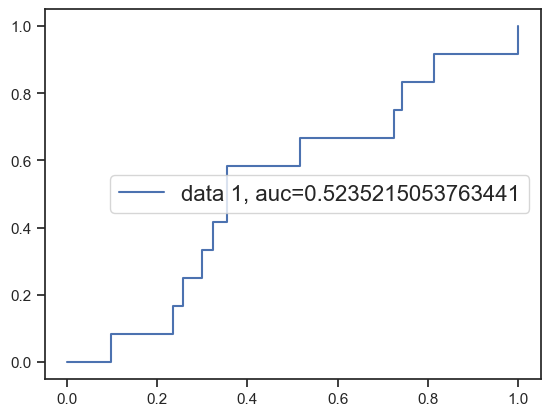

In [292]:
from sklearn.metrics import roc_curve
from sklearn import metrics

y_pred = np.asarray(list(np.stack(new_df['similarity'].values).reshape(-1)))
y_true = np.asarray(list(np.stack(new_df['pred'].values).reshape(-1)))
fpr, tpr, thresholds = roc_curve(y_true,y_pred)
# plt.plot(fpr, label = 'fpr')
# plt.plot(tpr, label = 'tpr')
plt.plot(fpr,tpr,label="data 1, auc="+str(metrics.auc(fpr, tpr)))
print("auc: ", metrics.auc(fpr, tpr))
plt.legend(fontsize=16)

In [241]:
dataHD = dataHD.query('DiseaseState != "0"')
dataHD.DiseaseState.value_counts()

D    1158
H     918
Name: DiseaseState, dtype: int64

explained variance:  0.4811822282748647


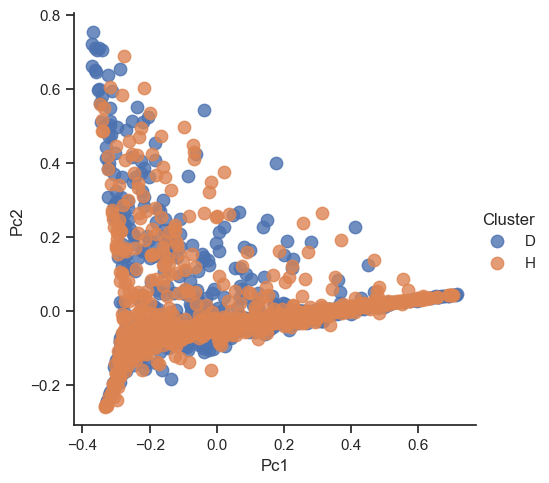

In [242]:
pca = PCA(n_components=2)
components_HD = pca.fit_transform(dataHD.query('DiseaseState != 0').drop(columns=['DiseaseState', 'From']))
print("explained variance: ", sum(pca.explained_variance_ratio_))
pca_HD = pd.DataFrame(data= components_HD, columns= ['Pc1', 'Pc2'])
pca_HD['Cluster'] = dataHD.query('DiseaseState != 0').DiseaseState

sns.lmplot( x="Pc1", y="Pc2",
data=pca_HD, 
fit_reg=False, 
hue='Cluster', # color by cluster
legend=True,
scatter_kws={"s": 80}) 


In [263]:
from sklearn.manifold import TSNE
tsne = TSNE(metric = 'braycurtis', perplexity=30.0)
embeddings = tsne.fit_transform(dataHD.drop(columns=['DiseaseState', 'From']))
embeddings = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3).fit_transform(dataHD.drop(columns=['DiseaseState', 'From']))
pca_HD = pd.DataFrame(data = embeddings, columns = ['Pc1', 'Pc2'])

c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\talno\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [262]:
import sklearn
sorted(sklearn.neighbors.VALID_METRICS['brute'])

['braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'correlation',
 'cosine',
 'dice',
 'euclidean',
 'hamming',
 'haversine',
 'jaccard',
 'kulsinski',
 'l1',
 'l2',
 'mahalanobis',
 'manhattan',
 'matching',
 'minkowski',
 'nan_euclidean',
 'precomputed',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'yule']

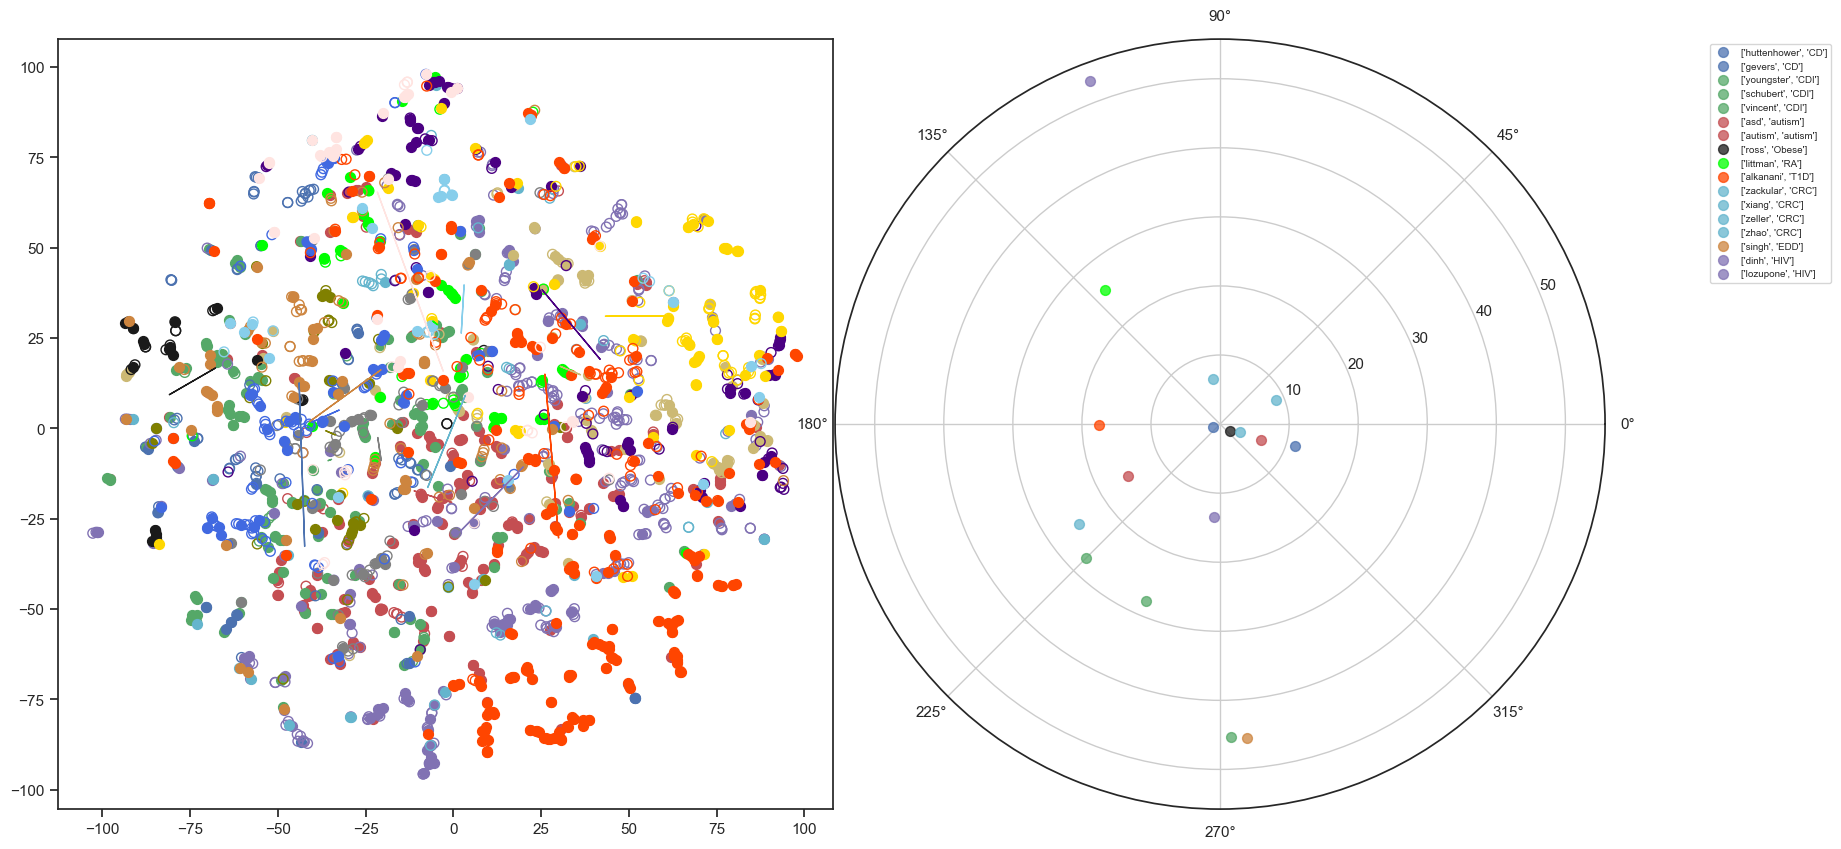

In [293]:

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, polar=True)

targets = [["huttenhower", "H"],["huttenhower", "D"], ["gevers", "H"],["gevers", "D"], ["youngster", "H"],["youngster", "D"], ["schubert", "H"],["schubert", "D"],["vincent", "H"],["vincent", "D"],["asd", "H"],["asd", "D"],["autism", "H"],["autism", "D"],["ross", "H"],["ross", "D"],["littman", "H"],["littman", "D"],["alkanani", "H"],["alkanani", "D"],["xiang", "H"],["xiang", "D"],["zackular", "H"],["zackular", "D"],["zeller", "H"],["zeller", "D"],["zhao", "H"],["zhao", "D"],["singh", "H"],["singh", "D"],["dinh", "H"],["dinh", "D"],["lozupone", "H"],["lozupone", "D"]]
colors = ['r', 'r', 'g', 'g', 'b', 'b','m', 'm', 'c', 'c','y','y','k','k','lime','lime','indigo','indigo','gold','gold','olive','olive','grey','grey','royalblue','royalblue','peru','peru','orangered','orangered','skyblue','skyblue','mistyrose','mistyrose']
arrows, var_x, var_y, angles, sizes = [], [], [], [], []
# axes[i].scatter(pca_americans1.loc[:,'Pc1'], pca_americans1.loc[:,'Pc2'],marker='.',s=2, color= 'g')
for target, color in zip(targets,colors):
    indicesToKeep = (dataHD['From'] == target[0]) & (dataHD['DiseaseState'] == target[1])
    fill = 'none'
    if target[1] == "D":
        # color = 'r'
        fill = color
    # else:
        # color = 'k'
    x = pca_HD.loc[indicesToKeep.values, 'Pc1'].values.mean()
    y = pca_HD.loc[indicesToKeep.values, 'Pc2'].values.mean()
    x_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc1'].values)
    y_v = np.var(pca_HD.loc[indicesToKeep.values, 'Pc2'].values)
    var_x.append(x_v)
    var_y.append(y_v)
    arrows.append(x)
    arrows.append(y)
    ax1.scatter(pca_HD.loc[indicesToKeep.values, 'Pc1'] , pca_HD.loc[indicesToKeep.values, 'Pc2'], c=fill, edgecolors=color, s=50)
# find centroids and plotting an arrow
col = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
for j in range(0,len(arrows),4):
    ax1.arrow(arrows[j], arrows[j+1], arrows[j+2]-arrows[j],arrows[j+3]-arrows[j+1], color=col[j//4])
    angles.append(math.atan2(arrows[j+3]-arrows[j+1],arrows[j+2]-arrows[j]))
    sizes.append(math.sqrt((arrows[j+2]-arrows[j])**2+(arrows[j+3]-arrows[j+1])**2))
L = ["huttenhower-CD", "gevers-CD", "youngster-CDI", "schubert-CDI","vincent-CDI","asd-ASD","autism","ross-OBESE","littman-RA","alkanani-T1D","xiang-CRC","zackular-CRC","zeller-CRC","zhao-CRC","singh-EDD","dinh-HIV","lozupone-HIV"]
plt.legend(L) 

colors = ['r', 'g', 'b', 'm', 'c','y','k','lime','indigo','gold','olive','grey','royalblue','peru','orangered','skyblue','mistyrose']
color_disease = {"CD": 'b', "CDI": 'g', "autism": 'r', "Obese": 'k', 'CRC': 'c', 'HIV': 'm', "EDD":'peru', "T1D": 'orangered', "RA": 'lime'}
L = [["huttenhower","CD"], ["gevers","CD"], ["youngster","CDI"], ["schubert","CDI"],["vincent","CDI"],["asd","autism"],["autism","autism"],["ross","Obese"],["littman","RA"],["alkanani","T1D"],["zackular","CRC"],["xiang","CRC"],["zeller","CRC"],["zhao","CRC"],["singh","EDD"],["dinh","HIV"],["lozupone","HIV"]]

for angle,name,size,x,y,color in zip(angles,L,sizes,var_x,var_y,colors):
    # ax2.errorbar(angle, size, xerr=x,yerr=y, c=color_disease[name[1]], alpha=1, marker='o')
    # ax2.errorbar(angle, size, xerr=x, yerr=y, c=color, alpha=0.75, marker='o')
    c = ax2.scatter(angle, size, c=color_disease[name[1]], alpha=0.75, s=50)
    # c = ax2.scatter(angle, size, c=color, alpha=0.75, s=50)
ax2.legend(L,prop={'size': 7}, bbox_to_anchor=(1.3, 1))
plt.show()